In [10]:
import logging
import time

import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds
import tensorflow as tf

# Import tf_text to load the ops used by the tokenizer saved model
import tensorflow_text  # pylint: disable=unused-import

In [5]:
logging.getLogger('tensorflow').setLevel(logging.ERROR)  # suppress warnings

In [6]:
examples, metadata = tfds.load('ted_hrlr_translate/pt_to_en', with_info=True,
                               as_supervised=True)
train_examples, val_examples = examples['train'], examples['validation']

2022-04-16 08:48:47.527278: W tensorflow/core/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "FAILED_PRECONDITION: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata".


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/51785 [00:00<?, ? examples/s]

Shuffling /Users/liujinghui/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0.incompleteCB823S/ted_hrlr_tr…

Generating validation examples...:   0%|          | 0/1193 [00:00<?, ? examples/s]

Shuffling /Users/liujinghui/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0.incompleteCB823S/ted_hrlr_tr…

Generating test examples...:   0%|          | 0/1803 [00:00<?, ? examples/s]

Shuffling /Users/liujinghui/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0.incompleteCB823S/ted_hrlr_tr…

Dataset ted_hrlr_translate downloaded and prepared to /Users/liujinghui/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0. Subsequent calls will reuse this data.


In [7]:
for pt_example, en_example in train_examples.batch(3).take(1):
    for pt in pt_example.numpy():
        print(pt.decode('utf-8'))

    print()

    for en in en_example.numpy():
        print(en.decode('utf-8'))

e quando melhoramos a procura , tiramos a única vantagem da impressão , que é a serendipidade .
mas e se estes fatores fossem ativos ?
mas eles não tinham a curiosidade de me testar .

and when you improve searchability , you actually take away the one advantage of print , which is serendipity .
but what if it were active ?
but they did n't test for curiosity .


2022-04-16 08:51:39.268607: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-04-16 08:51:39.300144: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [8]:
model_name = 'ted_hrlr_translate_pt_en_converter'
tf.keras.utils.get_file(
    f'{model_name}.zip',
    f'https://storage.googleapis.com/download.tensorflow.org/models/{model_name}.zip',
    cache_dir='.', cache_subdir='', extract=True
)

196608/184801 [===============================] - 0s 2us/step


'./ted_hrlr_translate_pt_en_converter.zip'

In [11]:
tokenizers = tf.saved_model.load(model_name)

In [13]:
[item for item in dir(tokenizers.en) if not item.startswith('_')]

['detokenize',
 'get_reserved_tokens',
 'get_vocab_path',
 'get_vocab_size',
 'lookup',
 'tokenize',
 'tokenizer',
 'vocab']

In [14]:
for en in en_example.numpy():
    print(en.decode('utf-8'))

and when you improve searchability , you actually take away the one advantage of print , which is serendipity .
but what if it were active ?
but they did n't test for curiosity .


In [15]:
encoded = tokenizers.en.tokenize(en_example)

for row in encoded.to_list():
    print(row)

[2, 72, 117, 79, 1259, 1491, 2362, 13, 79, 150, 184, 311, 71, 103, 2308, 74, 2679, 13, 148, 80, 55, 4840, 1434, 2423, 540, 15, 3]
[2, 87, 90, 107, 76, 129, 1852, 30, 3]
[2, 87, 83, 149, 50, 9, 56, 664, 85, 2512, 15, 3]


In [17]:
round_trip = tokenizers.en.detokenize(encoded)

for line in round_trip.numpy():
    print(line.decode('utf-8'))

and when you improve searchability , you actually take away the one advantage of print , which is serendipity .
but what if it were active ?
but they did n ' t test for curiosity .


In [18]:
tokens = tokenizers.en.lookup(encoded)
tokens

<tf.RaggedTensor [[b'[START]', b'and', b'when', b'you', b'improve', b'search', b'##ability',
  b',', b'you', b'actually', b'take', b'away', b'the', b'one', b'advantage',
  b'of', b'print', b',', b'which', b'is', b's', b'##ere', b'##nd', b'##ip',
  b'##ity', b'.', b'[END]']                                                 ,
 [b'[START]', b'but', b'what', b'if', b'it', b'were', b'active', b'?',
  b'[END]']                                                           ,
 [b'[START]', b'but', b'they', b'did', b'n', b"'", b't', b'test', b'for',
  b'curiosity', b'.', b'[END]']                                          ]>

In [23]:
lengths = []

for pt_examples,en_examples in train_examples.batch(1024):
    pt_tokens = tokenizers.en.tokenize(pt_examples)
    lengths.append(pt_tokens.row_lengths())

    en_tokens = tokenizers.en.tokenize(en_examples)
    lengths.append(en_tokens.row_lengths())

    print('.',end='',flush=True)

...................................................

Text(0.5, 1.0, 'Max tokens per example: 394')

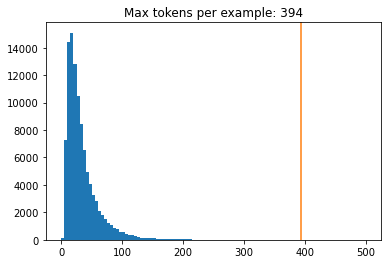

In [24]:
all_lengths = np.concatenate(lengths)

plt.hist(all_lengths,np.linspace(0,500,101))
plt.ylim(plt.ylim())
max_length = max(all_lengths)
plt.plot([max_length,max_length],plt.ylim())
plt.title(f'Max tokens per example: {max_length}')

In [39]:
MAX_TOKENS = 128

In [40]:
def filter_max_tokens(pt,en):
    num_tokens = tf.maximum(tf.shape(pt)[1],tf.shape(en)[1])
    return num_tokens<MAX_TOKENS

In [41]:
def tokenize_pairs(pt,en):
    pt = tokenizers.pt.tokenize(pt)

    pt = pt.to_tensor()

    en = tokenizers.en.tokenize(en)

    en = en.to_tensor()

    return pt,en

In [42]:
BUFFER_SIZE = 20000
BATCH_SIZE = 64

In [43]:
def make_batches(ds):
    return (
        ds
        .cache()
        .shuffle(BUFFER_SIZE)
        .batch(BATCH_SIZE)
        .map(tokenize_pairs,num_parallel_calls=tf.data.AUTOTUNE)
        .filter(filter_max_tokens)
        .prefetch(tf.data.AUTOTUNE)
    )

trian_batches = make_batches(train_examples)
val_batches = make_batches(val_examples)

In [50]:
a = np.arange(5).reshape(5,1)
b = np.arange(5).reshape(1,5)
c = a*b
c[:,0::2] = 1
c[:,1::2] = 0
c

array([[1, 0, 1, 0, 1],
       [1, 0, 1, 0, 1],
       [1, 0, 1, 0, 1],
       [1, 0, 1, 0, 1],
       [1, 0, 1, 0, 1]])

In [56]:
def get_angles(pos,i,d_model):
    angle_rates = 1 / np.power(1000,(2*(i//2))/np.float32(d_model))

    return pos*angle_rates

def positional_encoding(position,d_model):
    angle_rads = get_angles(
        np.arange(position)[:,np.newaxis],
        np.arange(d_model)[np.newaxis,:],
        d_model)

    angle_rads[:,0::2] = np.sin(angle_rads[:,0::2])
    angle_rads[:,1::2] = np.cos(angle_rads[:,1::2])

    pos_encoding = angle_rads[np.newaxis,...]
    return tf.cast(pos_encoding,dtype=tf.float32)

# pos_encoding = positional_encoding(2048,512)

(1, 2048, 512)


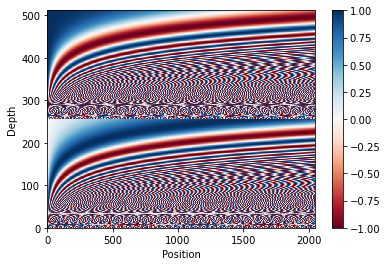

In [57]:
n,d = 2048,512
pos_encoding = positional_encoding(n,d)
print(pos_encoding.shape)
pos_encoding = pos_encoding[0]


# Juggle the dimensions for the plot
pos_encoding = tf.reshape(pos_encoding, (n, d//2, 2))
pos_encoding = tf.transpose(pos_encoding, (2, 1, 0))
pos_encoding = tf.reshape(pos_encoding, (d, n))

plt.pcolormesh(pos_encoding, cmap='RdBu')
plt.ylabel('Depth')
plt.xlabel('Position')
plt.colorbar()
plt.show()

In [59]:
def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq,0),tf.float32)

    return seq[:,tf.newaxis,tf.newaxis,:]

In [60]:
x = tf.constant([[7,6,0,0,1],[1,2,3,0,0],[0,0,0,4,5]])
create_padding_mask(x)

<tf.Tensor: shape=(3, 1, 1, 5), dtype=float32, numpy=
array([[[[0., 0., 1., 1., 0.]]],


       [[[0., 0., 0., 1., 1.]]],


       [[[1., 1., 1., 0., 0.]]]], dtype=float32)>

In [62]:
def create_look_ahead_mask(size):
    mask = 1-tf.linalg.band_part(tf.ones((size,size)),-1,0)
    return mask

In [63]:
x = tf.random.uniform((1,3))
tmp = create_look_ahead_mask(x.shape[1])
tmp

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[0., 1., 1.],
       [0., 0., 1.],
       [0., 0., 0.]], dtype=float32)>

In [64]:
def scaled_dot_product_attention(q,k,v,mask):
    matmul_qk = tf.matmul(q,k,transpose_b = True)

    dk = tf.cast(tf.shape(k)[-1],tf.float32)
    scaled_attention_logits = matmul_qk/tf.math.sqrt(dk)

    if mask is not None:
        scaled_attention_logits += (mask*-1e9)

    attention_weights = tf.nn.softmax(scaled_attention_logits,axis=-1)

    output = tf.matmul(attention_weights,v)

    return output,attention_weights


In [65]:
def print_out(q,k,v):
    temp_out,temp_attn = scaled_dot_product_attention(q,k,v,None)
    print(f'Attention weights r '
          f'{temp_attn}\n')
    print(f'Output is:'
          f'{temp_out}\n')

In [66]:
np.set_printoptions(suppress=True)

temp_k = tf.constant([[10, 0, 0],
                      [0, 10, 0],
                      [0, 0, 10],
                      [0, 0, 10]], dtype=tf.float32)  # (4, 3)

temp_v = tf.constant([[1, 0],
                      [10, 0],
                      [100, 5],
                      [1000, 6]], dtype=tf.float32)  # (4, 2)

# This `query` aligns with the second `key`,
# so the second `value` is returned.
temp_q = tf.constant([[0, 10, 0]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights r [[0. 1. 0. 0.]]

Output is:[[10.  0.]]



In [68]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self,*,d_model,num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads==0

        self.depth = d_model // self.num_heads

        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)

        self.dense = tf.keras.layers.Dense(d_model)

    def split_heads(self,x,batch_sz):
        x = tf.reshape(x,(batch_sz,-1,self.num_heads,self.depth))
        return tf.transpose(x,perm=[0,2,1,3])

    def call(self,q,k,v,mask):
        batch_sz = tf.shape(q)[0]

        q = self.wq(q)
        k = self.wk(k)
        v = self.wv(v)

        q = self.split_heads(q,batch_sz)
        k = self.split_heads(k,batch_sz)
        v = self.split_heads(v,batch_sz)

        scaled_attention, attention_weights = scaled_dot_product_attention(
            q,k,v,mask
        )

        scaled_attention = tf.transpose(scaled_attention,perm = [0,2,1,3])

        concat_attention = tf.reshape(scaled_attention,
                                      (batch_sz,-1,self.d_model))

        output = self.dense(concat_attention)

        return output,attention_weights

In [69]:
temp_mha = MultiHeadAttention(d_model=512,num_heads=8)
y = tf.random.uniform((32,10,64))
temp_output,temp_attention_weights = temp_mha(q=y,k=y,v=y,mask=None)
temp_output.shape,temp_attention_weights.shape

(TensorShape([32, 10, 512]), TensorShape([32, 8, 10, 10]))

In [73]:
def point_wise_feed_forward_network(d_model,dff):
    return tf.keras.Sequential([
        tf.keras.layers.Dense(dff,activation='relu'),
        tf.keras.layers.Dense(d_model)
    ])

In [71]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self,*,d_model,num_heads,dff,rate=0.1):
        super(EncoderLayer, self).__init__()

        self.mha = MultiHeadAttention(d_model=d,num_heads=num_heads)
        self.ffn = point_wise_feed_forward_network(d_model=d_model,dff=dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, x, training, mask):

        attn_output,_ = self.mha(x,x,x,mask)
        attn_output = self.dropout1(attn_output,training=training)
        out1 = self.layernorm1(x+attn_output)

        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output,training=training)
        out2 = self.layernorm2(out1+ffn_output)

        return out2

In [74]:
sample_encoder_layer = EncoderLayer(d_model=512,num_heads=8,dff=2048)

sample_encoder_layer_output = sample_encoder_layer(tf.random.uniform((64,43,512)),False,None)

sample_encoder_layer_output.shape

TensorShape([64, 43, 512])

In [75]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self,*,d_model,num_heads,dff,rate=0.1):
        super(DecoderLayer, self).__init__()

        self.mha1 = MultiHeadAttention(d_model=d_model,num_heads=num_heads)
        self.mha2 = MultiHeadAttention(d_model=d_model,num_heads=num_heads)

        self.ffn = point_wise_feed_forward_network(d_model=d_model,dff=dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)

    def call(self,x,enc_output,training,
             look_ahead_mask,padding_mask):
        attn1,attn_weights_block1 = self.mha1(x,x,x,look_ahead_mask)
        attn1 = self.dropout1(attn1,training=training)
        out1 = self.layernorm1(attn1+x)

        attn2,attn_weights_block2 = self.mha2(q=out1,k=enc_output,v=enc_output,mask=padding_mask)
        attn2 = self.dropout2(attn2,training=training)
        out2 = self.layernorm2(attn2+out1)

        ffn_output = self.ffn(out2)
        ffn_output = self.dropout3(ffn_output,training=training)
        out3 = self.layernorm3(ffn_output+out2)

        return out3,attn_weights_block1,attn_weights_block2

In [76]:
sample_decoder_layer = DecoderLayer(d_model=512,num_heads=8,dff=2048)

sample_decoder_layer_output,_,_ = sample_decoder_layer(
    tf.random.uniform((64,50,512)),sample_encoder_layer_output,
    False,None,None
)

sample_decoder_layer_output.shape

TensorShape([64, 50, 512])

In [77]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self,*,num_layers,d_model,num_heads,dff,input_vocab_size,rate):
        super(Encoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.emdedding = tf.keras.layers.Embedding(
            input_vocab_size,
            d_model
        )
        self.pos_encoding = positional_encoding((MAX_TOKENS,self.d_model))

        self.enc_layers = [
            EncoderLayer(d_model=d_model,num_heads=num_heads,dff=dff,rate=rate)
            for _ in range(num_layers)
        ]
        self.dropout = tf.keras.layers.Dropout(rate)

    def call(self,x,training,mask):
        seq_len = tf.shape(x)[1]

        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model,tf.float32))
        x += self.pos_encoding[:,:seq_len,:]

        x = self.dropout(x,training = training)

        for i in range(self.num_layers):
            x = self.enc_layers[i](x,training,mask)

        return x
